<a href="https://colab.research.google.com/github/Erfandarzi/mri-reconstruction/blob/master/Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!cp -r /content/drive/MyDrive/Reconstruction/ /content

In [ ]:

import os, glob, sys, io
import pathlib

from pprint import pprint
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import scipy
import scipy.signal
import scipy.interpolate

import pickle
from tqdm.auto import tqdm, trange


from IPython.core.display import display, HTML

In [ ]:
out_dir = "F:/MohammadRaziei/project/Dataset/ismrmrd_to_npz"
# out_dir = "H:/Dataset/Bio/MRI Reconstruction/ismrmrd_to_npz"
pickle_dir = "F:/MohammadRaziei/project/Dataset/npz_to_pickle"
# pickle_dir = "H:/Dataset/Bio/MRI Reconstruction/npz_to_pickle"
pickle_batch_root = "F:/MohammadRaziei/project/Dataset/pickle_batch_root"

filenames = glob.glob(out_dir+"/*.npz")
len(filenames)

0

In [ ]:
batch_size = 64
data_root = os.path.join(pickle_batch_root, str(batch_size))
pathlib.Path(data_root).mkdir(parents=True, exist_ok=True)

In [ ]:
all_info = [np.load(fname, allow_pickle=True)['info'].item() for fname in filenames]
pd_info = pd.DataFrame(all_info)
pd_info

""


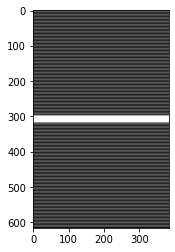

In [ ]:
mNx, mNy = (384, 616)

mask_k = np.zeros((mNy, mNx))
mask_k[::4,:] = 1

w = 10;
mask_w = np.zeros((mNy, mNx))
mask_w[mNy//2-w:mNy//2+w,:] = 1

mask_t = np.logical_or(mask_k, mask_w)

plt.imshow(mask_t, cmap='gray')#,interpolation='none')
plt.show()

In [ ]:
class KSpaceCatGenerator(tf.keras.utils.Sequence):
    def __init__(self, pickle_root_dir, mask, axis, data_format="channels_first"):
        self.filenames = glob.glob(pickle_root_dir+"/*.pickle")
        self.mask = mask
        self.data_root = pickle_root_dir
        self.axis = axis
        assert(data_format in ["channels_first", "channels_last"])
        self.data_format = data_format
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        return self.getitem(index)
        
    def getitem(self, index):
        with open(self.filenames[index], 'rb') as f:
            padded = pickle.load(f)
        inp = padded*self.mask
        out1 = padded
        if self.data_format =="channels_last":
            inp = inp.transpose([0,2,3,1])
            out1 = out1.transpose([0,2,3,1])        
        inp = self.to_float(inp, self.axis)
        out1 = self.to_float(out1, self.axis)
        return inp, out1
    
    
    def get_batch_size(self):
        return int(pathlib.Path(self.data_root).stem)
    
    @staticmethod
    def to_float(X, axis):
        return np.concatenate([X.real, X.imag], axis=axis)
    @staticmethod
    def to_float(X, axis):
        return np.concatenate([X.real, X.imag], axis=axis)
    @staticmethod
    def to_complex(X, axis):
        ax = np.mod(axis, 4)
        n = X.shape[ax] // 2
        if   ax == 0: a = X[:n,:,:,:] + 1j * X[n:,:,:,:]
        elif ax == 1: a = X[:,:n,:,:] + 1j * X[:,n:,:,:]
        elif ax == 2: a = X[:,:,:n,:] + 1j * X[:,:,n:,:]
        elif ax == 3: a = X[:,:,:,:n] + 1j * X[:,:,:,n:]
        else: raise Exception("not suported axis")
        return a
        
    def transform_to_image_coils(self, data):
        axes = (-2,-1) if self.data_format == "channels_first" else (1,2)
        return np.fft.fftshift(scipy.fft.ifft2(self.to_complex(data, self.axis), axes=axes,
                                              workers=os.cpu_count()))
    def combine_coil_images(self, im):
        return np.sqrt(np.sum(im**2,1 if self.data_format == "channels_first" else 3))
    def transform_to_images(self, data):
        return self.combine_coil_images(self.transform_to_image_coils(data))


In [ ]:
pathlib.Path(data_root).mkdir(parents=True, exist_ok=True)

In [ ]:
batch_size = 64
pickle_batch_root = '/content/pickle_batch_root'
data_root = os.path.join(pickle_batch_root, str(batch_size))
pathlib.Path(data_root).mkdir(parents=True, exist_ok=True)

In [ ]:
!mv /content/Reconstruction/0000.pickle /content/pickle_batch_root/64/0000.pickle

In [ ]:
kspacegen = KSpaceCatGenerator(data_root, mask_t,1)
print(len(kspacegen))
print(kspacegen.get_batch_size())

1
64


In [ ]:
%time X,Y = kspacegen[0]


CPU times: user 2.4 s, sys: 3.39 s, total: 5.78 s
Wall time: 35.5 s


In [ ]:
data_root_A= '/content/Reconstruction/data/train/A'
pathlib.Path(data_root_A).mkdir(parents=True, exist_ok=True)

In [ ]:
data_root_B= '/content/Reconstruction/data/train/B'
pathlib.Path(data_root_B).mkdir(parents=True, exist_ok=True)

In [ ]:
from PIL import Image
import os

for i in range (len(Y)):
    path=os.path.join(data_root_A,str(i)+'_'+batch_name+'.pickle')
    with open(path, "wb") as f_out:
        pickle.dump(Y[i], f_out)
  

In [ ]:
for i in range (len(X)):
    path=os.path.join(data_root_B,str(i)+'_'+batch_name+'.pickle')
    with open(path, "wb") as f_out:
        pickle.dump(X[i], f_out)

In [ ]:
with open("/content/Reconstruction/data/train/A/11_0000.pickle", "rb") as f_in:
    arr_new = pickle.load(f_in)
    print (arr_new.shape)

(30, 616, 384)


In [ ]:
X.shape

(64, 15, 616, 384)

CPU times: user 13.9 s, sys: 2.2 s, total: 16.1 s
Wall time: 9.98 s


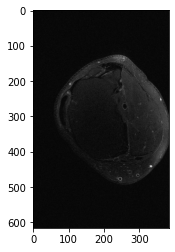

CPU times: user 17.4 s, sys: 770 ms, total: 18.1 s
Wall time: 10.5 s


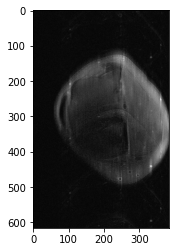

In [ ]:
%time images = KSpaceGenerator.transform_to_images(Y)
plt.imshow(np.abs(images[21]), cmap='gray')
plt.show()
%time images_alias = KSpaceGenerator.transform_to_images(X)
plt.imshow(np.abs(images_alias[21]), cmap='gray')
plt.show()

In [ ]:
!mkdir '/content/Reconstruction/output'

In [ ]:
%cd /content/Reconstruction
!python train.py  --dataroot /content/Reconstruction/data --cuda --input_nc=30 --output_nc 30 --epoch 1 --n_cpu=2

In [10]:
######## TEST ##########

import torch
import pickle
import numpy as np
from PIL import Image
sample_pickle='/content/Reconstruction/data/train/A/12_0000.pickle'

with open(sample_pickle, 'rb') as pickle_file:
    item_B = pickle.load(pickle_file)

item_B_resized=np.zeros((30,287,287))

for i in range (len(item_B)):
    item_B_pil= Image.fromarray(item_B[i])
    item_B_resized[i]= np.array(item_B_pil.resize((287,287),Image.BICUBIC))
item_B= torch.tensor(item_B_resized)
netG_A2B= torch.load('/content/Reconstruction/output/netG_A2B.pth')

TypeError: ignored

In [ ]:
netG_A2B ()

In [ ]:
!cp -r /content/Reconstruction  /content/drive/MyDrive

In [ ]:
!mkdir "/content/drive/MyDrive/Reconstruction"

In [ ]:
####### HATMAN NORMALIZATiON preprpcessing ro anjam bede (0.5,0.5,0.5)